In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


class anom_detect():
    def __init__(self,method='average',window=5,max_outliers=None,alpha=0.05,mode='same'):
        self.method = method
        self.window = window
        self.max_outliers = max_outliers
        self.alpha = alpha
        self.mode = mode

    def moving_average(self,f_t):
        if type(f_t) is not np.ndarray:
            raise TypeError\
                ('Expected one dimensional numpy array.')
        if f_t.shape[1] != 1:
            raise IndexError\
                ('Expected one dimensional numpy array, %d dimensions given.' % (f_t.shape[1]))

        f_t = f_t.flatten()
        window = self.window
        mode = self.mode
        g_t = np.ones(int(window))/float(window)
        # Deal with boundaries with atleast lag/2 day window
        #mode = 'same'
        rolling_mean = np.convolve(f_t,g_t,mode)
        self.rolling_mean = rolling_mean
        return rolling_mean

    def deviation_stats(self,df):
        df['mean_count'] = self.rolling_mean
        df['residual'] = df.iloc[:,0] - self.rolling_mean
        std_resid = np.std(df.residual)
        df['pos_std'] = df.mean_count + std_resid
        df['neg_std'] = df.mean_count - std_resid
        df['pos_std_2'] = df.mean_count + 2*std_resid
        df['neg_std_2'] = df.mean_count - 2*std_resid
        return df

    def normality(self):
        if self.results is not None:
            df = self.results
            fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 6))
            x = df.residual.values
            re = stats.probplot(x, plot=ax2)
            ax1.hist(df.residual,bins=100);
            ax1.set_title('Distribution of Residuals');
        else:
            raise NameError\
                ('The moving average for the data has not yet been computed.  Run moving_averge or evaluate prior to normality.')


    def esd_test(self,df_in):
        ind = list(df_in.index)
        x = list(df_in.values)
        outliers = []
        res_lst = [] # ESD Test Statistic for each k anomaly
        lam_lst = [] # Critical Value for each k anomaly
        n = len(x)

        if self.max_outliers is None:
            self.max_outliers = len(x)

        for i in range(1,self.max_outliers+1):
            x_mean = np.mean(x)
            x_std = np.std(x,ddof=1)
            res = abs((x - x_mean) / x_std)
            max_res = np.max(res)
            max_ind = np.argmax(res)
            p = 1 - self.alpha / (2*(n-i+1))
            t_v = stats.t.ppf(p,(n-i-1)) # Get critical values from t-distribution based on p and n
            lam_i = ((n-i)*t_v)/ np.sqrt((n-i-1+t_v**2)*(n-i+1)) # Calculate critical region (lambdas)
            res_lst.append(max_res)
            lam_lst.append(lam_i)
            if max_res > lam_i:
                outliers.append((ind.pop(max_ind),x.pop(max_ind)))
        # Record outlier Points
        outliers_index = [x[0] for x in outliers]

        ESD_stats = pd.DataFrame()
        ESD_stats['ESD Test Statistic'] = res_lst
        ESD_stats['Critical Value'] = lam_lst
        self.ESD_stats = ESD_stats

        return outliers_index

    def ESD_plot(self):
        self.ESD_stats.plot()

    def plot(self,data_label=None,left=None,right=None,bottom=None,top=None):
        df = self.results
        anoma_points = self.anoma_points
        fig, ax1 = plt.subplots(1, 1,figsize=(15, 8))
        ax1.plot(list(df.index),df.iloc[:,0],'b.',label=data_label)
        ax1.plot(list(df.index),df.mean_count,'r',label='Moving Average')
        ax1.fill_between(df.index,df.pos_std,df.neg_std,color='red',alpha=0.3,label='1Sigma')
        ax1.fill_between(df.index,df.pos_std_2,df.neg_std_2,color='red',alpha=0.1,label='2Sigma')
        ax1.plot(list(anoma_points.index),anoma_points.iloc[:,0],'r*',label='Anomalous Points')
        ax1.set_xlabel('time')
        ax1.set_ylabel(data_label)
        ax1.set_title('Data with Anomalies starred')
        ax1.set_xlim(left=left,right=right)
        ax1.set_ylim(bottom=bottom,top=top)
        ax1.legend();

    def evaluate(self,data,anom_detect=True):
        df = pd.DataFrame(data)
        df.sort_index()

        if df.shape[1] != 1:
            raise IndexError\
                ('Insufficient dimensions provided, input data needs time and value columns.')

        if self.method == 'average':
            data_points = df.values
            self.moving_average(data_points)
            df = self.deviation_stats(df)
            self.results = df

        if anom_detect:
            outliers_index = self.esd_test(df[['residual']])
            anoma_points = pd.DataFrame(df[['sunspots']].iloc[outliers_index,0].sort_index())
            self.anoma_points = anoma_points
            return anoma_points


In [2]:
import pandas as pd

In [3]:
d1 = pd.read_csv('Downloads/d1.csv')
d2 = pd.read_csv('Downloads/d2.csv')
d3 = pd.read_csv('Downloads/d3.csv')

In [4]:
d1 = d1[['brand','bytes_in','bytes_out','pkts_in','pkts_out','time_gap']]
d2 = d2[['brand','bytes_in','bytes_out','pkts_in','pkts_out','time_gap']]
d3 = d3[['brand','bytes_in','bytes_out','pkts_in','pkts_out','time_gap']]

In [5]:
d1.head()

,brand,bytes_in,bytes_out,pkts_in,pkts_out,time_gap
0,萤石,225.0,468.0,2.0,5.0,0.0
1,其它,336.0,528.0,8.0,8.0,180.0
2,其它,0.0,90.0,0.0,1.0,0.0
3,其它,336.0,528.0,8.0,8.0,180.0
4,其它,336.0,528.0,8.0,8.0,180.0


In [6]:
b_i_1 = d1[['bytes_in']]
b_i_1.index.name = 'time'
b_i_1.columns = ['sunspots']
b_i_1 = b_i_1[b_i_1.sunspots > 0]
b_i_1.shape

(31079, 1)

In [7]:
b_i_1 = b_i_1.reset_index()

In [8]:
b_i_1 = b_i_1[['sunspots']]
b_i_1.index.name = 'time'
b_i_1.head()

,sunspots
time,
0,225.0
1,336.0
2,336.0
3,336.0
4,265.0


In [9]:
an = anom_detect()

In [10]:
an.evaluate(b_i_1)

,sunspots
time,
73,6462.0
75,265.0
77,6586.0
97,6586.0
107,9644.0
113,3553.0
139,6586.0
147,5698.0
164,8609.0


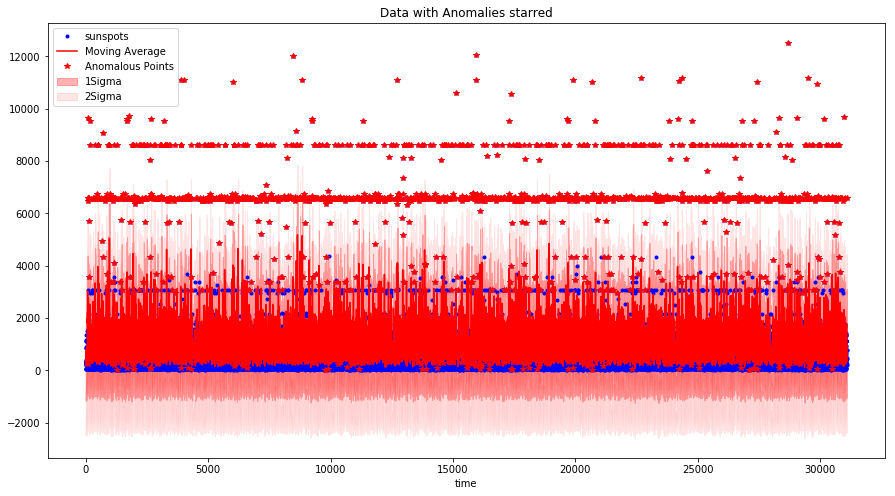

In [11]:
an.plot()

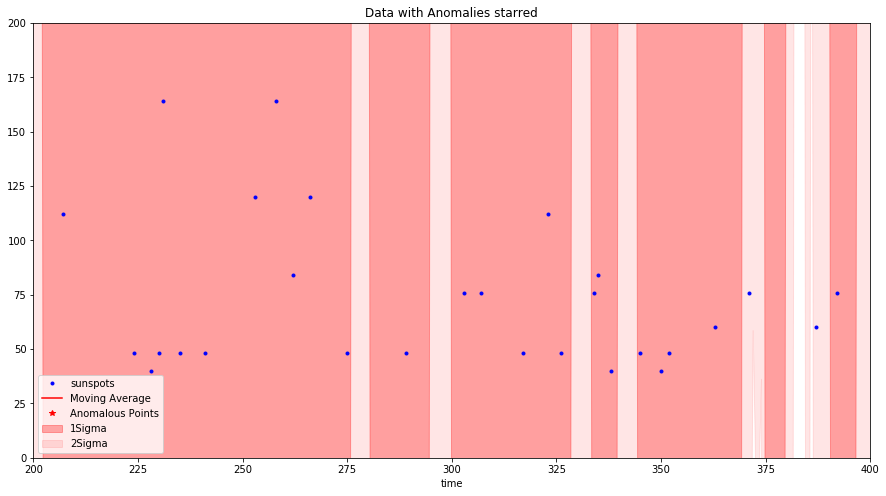

In [12]:
an.plot(left=200,right=400,top=200,bottom=0)

In [13]:
an.results.head()

,sunspots,mean_count,residual,pos_std,neg_std,pos_std_2,neg_std_2
time,,,,,,,
0,225.0,179.4,45.6,1517.755151,-1158.955151,2856.110301,-2497.310301
1,336.0,246.6,89.4,1584.955151,-1091.755151,2923.310301,-2430.110301
2,336.0,299.6,36.4,1637.955151,-1038.755151,2976.310301,-2377.110301
3,336.0,266.6,69.4,1604.955151,-1071.755151,2943.310301,-2410.110301
4,265.0,380.0,-115.0,1718.355151,-958.355151,3056.710301,-2296.710301


In [14]:
an.anoma_points.head()

,sunspots
time,
73,6462.0
75,265.0
77,6586.0
97,6586.0
107,9644.0


In [57]:
!wget -c http://www-personal.umich.edu/~mejn/cp/data/sunspots.txt

--2019-06-06 16:35:45--  http://www-personal.umich.edu/~mejn/cp/data/sunspots.txt
Resolving www-personal.umich.edu (www-personal.umich.edu)... 141.211.243.103
Connecting to www-personal.umich.edu (www-personal.umich.edu)|141.211.243.103|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30244 (30K) [text/plain]
Saving to: ‘sunspots.txt’

sunspots.txt        100%[===================>]  29.54K  8.97KB/s    in 3.3s    

2019-06-06 16:35:50 (8.97 KB/s) - ‘sunspots.txt’ saved [30244/30244]



In [58]:
df = pd.read_csv('sunspots.txt',sep='\t',header=None)
df.index.name = 'time'
df.columns = ['sunspots']

/home/ian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [59]:
df.head()

,sunspots
time,
0,58.0
1,62.6
2,70.0
3,55.7
4,85.0


In [61]:
an = anom_detect()

In [62]:
an.evaluate(df)

,sunspots
time,
10,158.6
42,78.4
239,111.8
253,142.5
255,51.0
262,132.2
264,36.0
268,152.7
270,67.7


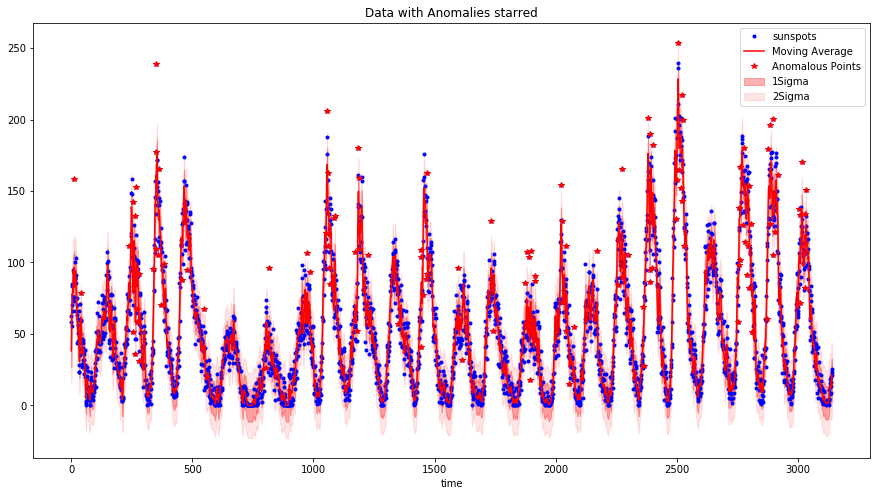

In [63]:
an.plot()

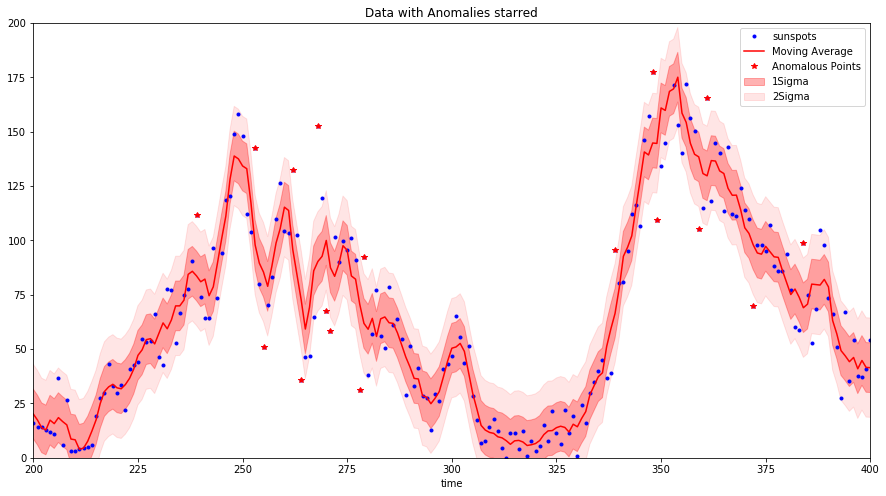

In [64]:
an.plot(left=200,right=400,top=200,bottom=0)

In [65]:
# The graph values can be accessed using 'results'.
an.results.head()

,sunspots,mean_count,residual,pos_std,neg_std,pos_std_2,neg_std_2
time,,,,,,,
0,58.0,38.12,19.88,49.544234,26.695766,60.968468,15.271532
1,62.6,49.26,13.34,60.684234,37.835766,72.108468,26.411532
2,70.0,66.26,3.74,77.684234,54.835766,89.108468,43.411532
3,55.7,71.36,-15.66,82.784234,59.935766,94.208468,48.511532
4,85.0,77.80,7.20,89.224234,66.375766,100.648468,54.951532


In [66]:
# Anomalous data points can be printed from anoma_points.
an.anoma_points.head()

,sunspots
time,
10,158.6
42,78.4
239,111.8
253,142.5
255,51.0
